# Case Tabas
O presente estudo tem por objetivo precificar imóveis para longa e curta estadia. 
A base utilizada trata-se de uma planilha excel contendo 4 abas, sendo:

1.   Apresentação do case;
2.   To Price (dataset a ser precificado);
3.   Apartments contendo os dados a serem analisados;
4.   Dicionário de dados.


# Bibliotecas

In [65]:
!pip install pandasql
!pip install folium
!pip install -U scikit-learn

In [93]:
#Import libs
import folium
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
from pandasql import sqldf
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans ,AgglomerativeClustering
from sklearn import datasets, linear_model
import statsmodels.api as sm
from scipy import stats



---



# Leitura dos arquivos

In [67]:
# carrega arquivo
df = pd.ExcelFile('df_tabas.xlsx')

# 'extrai' aba 1
df_price = pd.read_excel(df, sheet_name='To price')

# 'extrai' aba 2
df_ap = pd.read_excel(df, sheet_name='Apartments')

# 'extrai' aba 3
df_location = pd.read_excel(df, sheet_name='Location')



---



# Tabela To Price

In [173]:
df_price.head(6)

id  sqm  bedrooms   latitude  longitude  short_stay  long_stay
0   1   90         2 -23.562626 -46.661460      186.96      78.26
1   2   55         1 -23.564739 -46.664567       93.48      39.13
2   3  120         3 -23.557638 -46.665484      280.44     117.39
3   4   75         2 -23.587535 -46.677992      186.96      78.26
4   5  140         3 -23.584378 -46.678645      280.44     117.39
5   6   40         1 -23.583394 -46.681149       93.48      39.13

In [69]:
df_price.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         6 non-null      int64  
 1   sqm        6 non-null      int64  
 2   bedrooms   6 non-null      int64  
 3   latitude   6 non-null      float64
 4   longitude  6 non-null      float64
dtypes: float64(2), int64(3)
memory usage: 368.0 bytes


- O dataset não contem nenhum dados nulos



---



# Tabela Apartments

In [70]:
df_ap.head()

id  location_id  rent_type  price_month  sqm  bedrooms
0  47921         6023  long stay         5700   65         2
1  47947         6034  long stay         3000   30         1
2  47922        17486  long stay         2300   29         1
3  47923        17551  long stay         3880  130         2
4  47925        17843  long stay        12000  280         3

In [71]:
#verificando linhas e colunas
df_ap.shape

(6021, 6)

In [8]:
df_ap.isnull().sum()

id             0
location_id    0
rent_type      0
price_month    0
sqm            0
bedrooms       0
dtype: int64

- O dataset não contem nenhum dados nulos

# Verificando o comportamento dos dados

In [9]:
df_ap.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6021 entries, 0 to 6020
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           6021 non-null   int64 
 1   location_id  6021 non-null   int64 
 2   rent_type    6021 non-null   object
 3   price_month  6021 non-null   int64 
 4   sqm          6021 non-null   int64 
 5   bedrooms     6021 non-null   int64 
dtypes: int64(5), object(1)
memory usage: 282.4+ KB


# Verificando o comportamento das variáveis numéricas

In [72]:
df_ap.describe().round(1).T


count     mean      std  ...      50%      75%       max
id           6021.0  61140.8  14395.4  ...  50929.0  78910.0   80571.0
location_id  6021.0   9987.9   5342.6  ...   7797.0  10603.0   20919.0
price_month  6021.0   5064.3   7183.8  ...   3800.0   5700.0  279000.0
sqm          6021.0     91.6     71.9  ...     65.0    109.0    1000.0
bedrooms     6021.0      1.8      1.0  ...      2.0      3.0       6.0

[5 rows x 8 columns]


- Há um valor máximo de R$ 279.000,00 na feature de locação mensal; 
- A média de valores mensais para locação é de 5.064,31.

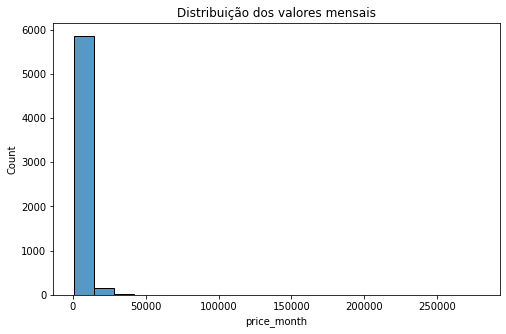

In [73]:
plt.figure(figsize=(8,5))
sns.histplot(data=df_ap, x='price_month', bins=20)
plt.title('Distribuição dos valores mensais')
plt.show()



---



#Tabela Location

In [74]:
df_location.head()

id  latitude  longitude
0  17475 -23.56242  -46.66976
1  17478 -23.56762  -46.65860
2  17481 -23.56630  -46.66320
3   6055 -23.56209  -46.65600
4   6056 -23.57087  -46.66174

In [75]:
df_location.describe().round(1).T

count    mean     std    min     25%     50%      75%      max
id         4471.0  9523.2  4700.6  711.0  6733.5  7851.0  10356.5  20919.0
latitude   4471.0   -23.6     0.4  -23.7   -23.6   -23.6    -23.6      0.0
longitude  4471.0   -46.7     0.7  -46.8   -46.7   -46.7    -46.7      0.0

In [15]:
df_location.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4471 entries, 0 to 4470
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         4471 non-null   int64  
 1   latitude   4471 non-null   float64
 2   longitude  4471 non-null   float64
dtypes: float64(2), int64(1)
memory usage: 104.9 KB


---

# Unindo os dataframes para enriquecer a base

In [76]:
pysqldf = lambda q: sqldf(q, globals())
 

q = """SELECT ap.id, ap.location_id, ap.rent_type, ap.price_month, ap.sqm, ap.bedrooms, loc.id as id_df_location, loc.latitude, loc.longitude 
       FROM df_ap as ap
       LEFT JOIN df_location as loc
       ON ap.location_id = loc.id;"""

 

df_full = pysqldf(q)
df_full

id  location_id   rent_type  ...  id_df_location  latitude  longitude
0     47921         6023   long stay  ...            6023 -23.57186  -46.65985
1     47947         6034   long stay  ...            6034 -23.57141  -46.65992
2     47922        17486   long stay  ...           17486 -23.57084  -46.65769
3     47923        17551   long stay  ...           17551 -23.57018  -46.66330
4     47925        17843   long stay  ...           17843 -23.57263  -46.65829
...     ...          ...         ...  ...             ...       ...        ...
6016  80292        10484  short stay  ...           10484 -23.59901  -46.68382
6017  80570        10737  short stay  ...           10737 -23.61920  -46.68528
6018  80571        10738  short stay  ...           10738 -23.60622  -46.66272
6019  80335        10523  short stay  ...           10523 -23.58300  -46.67900
6020  80317        10506  short stay  ...           10506 -23.59414  -46.68360

[6021 rows x 9 columns]

In [77]:
df_full.drop(columns=['id_df_location'], inplace=True)
display(df_full)

id  location_id   rent_type  ...  bedrooms  latitude  longitude
0     47921         6023   long stay  ...         2 -23.57186  -46.65985
1     47947         6034   long stay  ...         1 -23.57141  -46.65992
2     47922        17486   long stay  ...         1 -23.57084  -46.65769
3     47923        17551   long stay  ...         2 -23.57018  -46.66330
4     47925        17843   long stay  ...         3 -23.57263  -46.65829
...     ...          ...         ...  ...       ...       ...        ...
6016  80292        10484  short stay  ...         1 -23.59901  -46.68382
6017  80570        10737  short stay  ...         0 -23.61920  -46.68528
6018  80571        10738  short stay  ...         1 -23.60622  -46.66272
6019  80335        10523  short stay  ...         2 -23.58300  -46.67900
6020  80317        10506  short stay  ...         1 -23.59414  -46.68360

[6021 rows x 8 columns]

In [78]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6021 entries, 0 to 6020
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           6021 non-null   int64  
 1   location_id  6021 non-null   int64  
 2   rent_type    6021 non-null   object 
 3   price_month  6021 non-null   int64  
 4   sqm          6021 non-null   int64  
 5   bedrooms     6021 non-null   int64  
 6   latitude     6021 non-null   float64
 7   longitude    6021 non-null   float64
dtypes: float64(2), int64(5), object(1)
memory usage: 376.4+ KB




---



# Análise Exploratória

In [175]:
#gráfico de dispersão
sns.pairplot(data = df_full, vars=['bedrooms','price_month','sqm', 'rent_type'])
plt.show()

- É possível identificar imóveis com 0 quartos;
- Imóveis com 3 quartos são a maioria;
- Há imóveis com 6 quartos com o valor próximo ao eixo 0;
- há imóveis com 6 quartos e o tamanho muito pequeno quando comparado com os demais (aqui pode ser um ponto de atenção);
- Imóveis com preços menores tendem a ser alugados para longa estadia;
- Há uma concentração maior de locação de imóveis para curta longa estadia.

In [176]:
#matriz de correlação
df_full[['bedrooms','price_month','sqm']].corr()

sns.heatmap(df_full[['bedrooms','price_month','sqm']].corr(), annot=True, cmap = 'cividis')
plt.show()

In [21]:
#box plot
sns.boxplot (df_full.rent_type, df_full.bedrooms) 
plt.show ()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


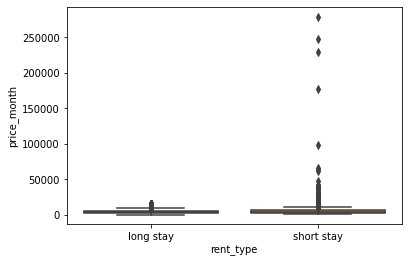

In [22]:
#box plot
sns.boxplot (df_full.rent_type, df_full.price_month) 
plt.show ()

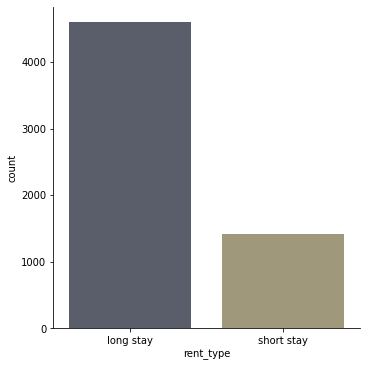

In [177]:
sns.catplot(x="rent_type", kind="count", palette='cividis', data=df_full)

- Na distribuição, verifica-se que há uma grande procura por locação para longa estadia

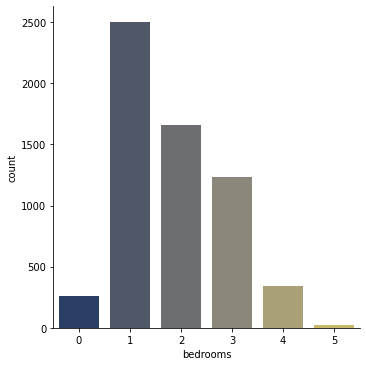

In [178]:
sns.catplot(x="bedrooms", kind="count", palette='cividis', data=df_full)

- No gráfico observa-se a distribuição de locação por numero de quartos, sendo há uma tendência maior de locação com 1 quarto;
- Ha um número expressivo de locações de imóveis com 0 quartos.

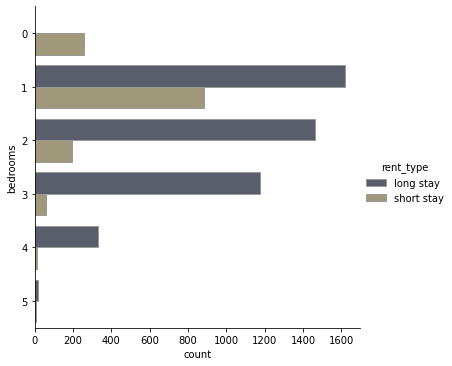

In [179]:
sns.catplot(y="bedrooms", hue="rent_type", kind="count",
             palette='cividis', edgecolor=".6",
            data=df_full)

- Imóveis com 0 quartos estão sendo usados apenas para estadias curtas

In [80]:
df_full.groupby(['rent_type', 'bedrooms'])['bedrooms'].count()

rent_type   bedrooms
long stay   1           1618
            2           1462
            3           1175
            4            329
            5             17
            6              1
short stay  0            258
            1            886
            2            195
            3             61
            4             14
            5              5
Name: bedrooms, dtype: int64

- confimação da afirmação anterior

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


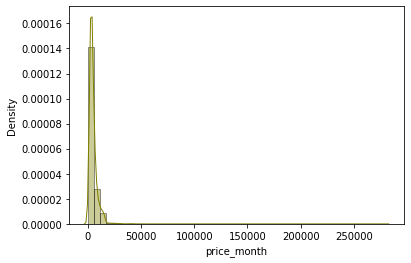

In [182]:
sns.distplot(df_full["price_month"], hist=True, kde=True, 
             color = 'olive', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 1})

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


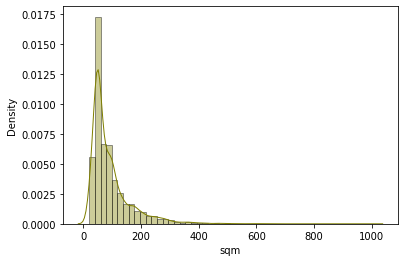

In [183]:
sns.distplot(df_full["sqm"], hist=True, kde=True, 
             color = 'olive', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 1})

- Os histogramas de preços por mês e metros quadrados estão deslocados para a esquerda. Ou seja, eles não representam uma distribuição normal.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


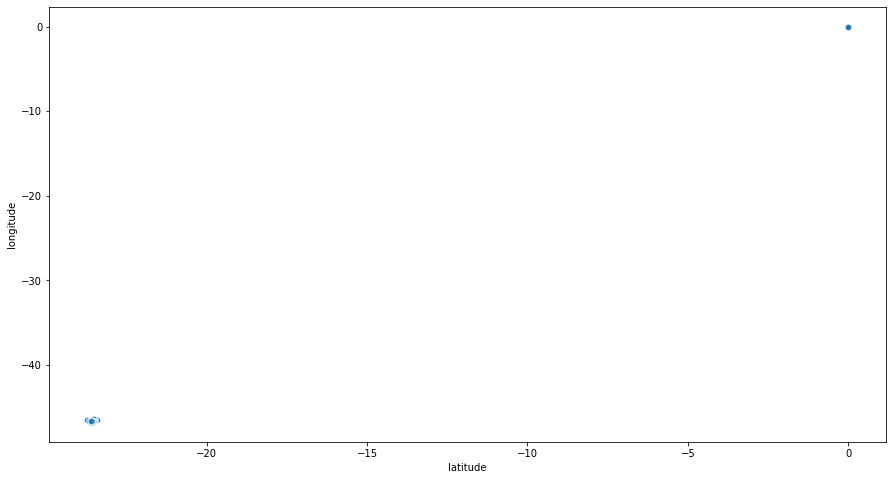

In [29]:
plt.figure(figsize = (15,8))
sns.scatterplot(df_full["latitude"], df_full["longitude"])

In [30]:
df_full[["latitude", "longitude"]]

latitude  longitude
0    -23.57186  -46.65985
1    -23.57141  -46.65992
2    -23.57084  -46.65769
3    -23.57018  -46.66330
4    -23.57263  -46.65829
...        ...        ...
6016 -23.59901  -46.68382
6017 -23.61920  -46.68528
6018 -23.60622  -46.66272
6019 -23.58300  -46.67900
6020 -23.59414  -46.68360

[6021 rows x 2 columns]

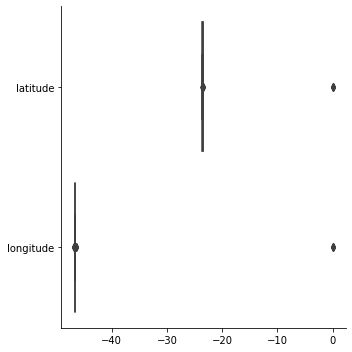

In [31]:
sns.catplot(data=df_full[["latitude", "longitude"]], orient="h", kind="box")

- a maioria dos imóveis estão distribuídos em outras regiões, enquanto há um ponto de latitude e longitude próximo de 0

In [82]:
map_pickup = folium.Map( location=[df_full["latitude"][0],df_full["longitude"][0]])

In [83]:
df_full.apply(lambda df_full:folium.CircleMarker(location=[df_full["latitude"], df_full["longitude"]] ).add_to(map_pickup), axis=1)

0       <folium.vector_layers.CircleMarker object at 0...
1       <folium.vector_layers.CircleMarker object at 0...
2       <folium.vector_layers.CircleMarker object at 0...
3       <folium.vector_layers.CircleMarker object at 0...
4       <folium.vector_layers.CircleMarker object at 0...
                              ...                        
6016    <folium.vector_layers.CircleMarker object at 0...
6017    <folium.vector_layers.CircleMarker object at 0...
6018    <folium.vector_layers.CircleMarker object at 0...
6019    <folium.vector_layers.CircleMarker object at 0...
6020    <folium.vector_layers.CircleMarker object at 0...
Length: 6021, dtype: object

In [84]:
map_pickup

- observa-se que os imóveis se encontram na região de São Paulo



---



# Verificando os Outliers encontrados
- imóvel de 6 quartos
- latitude e longitude 0

In [85]:
df_full[df_full['bedrooms'] == 6]

id  location_id  rent_type  ...  bedrooms  latitude  longitude
2414  49689         6795  long stay  ...         6  -23.5554  -46.67812

[1 rows x 8 columns]

In [86]:
df_full[df_full['latitude'] == 0]

id  location_id  rent_type  ...  bedrooms  latitude  longitude
1159  50107         6434  long stay  ...         3       0.0        0.0
1198  50195         6434  long stay  ...         2       0.0        0.0
2756  48726         6434  long stay  ...         1       0.0        0.0
4374  49200         6434  long stay  ...         2       0.0        0.0

[4 rows x 8 columns]

- existe mais de um imóvel com latitude e longitude igual a zero.
Longitude 0 e latitude 0 fica nas águas tropicais do leste do Oceano Atlântico (ver detalhes nesse [link](https://www.greelane.com/pt/humanidades/geografia/prime-meridian-and-the-equator-intersect-4070819/))



---



# Removendo os Outliers

In [87]:
df_full = df_full[(df_full['latitude'] != 0) & (df_full['bedrooms'] != 6)]

In [88]:
df_full[df_full['bedrooms'] == 6]

Empty DataFrame
Columns: [id, location_id, rent_type, price_month, sqm, bedrooms, latitude, longitude]
Index: []

In [89]:
df_full[df_full['latitude'] == 0]

Empty DataFrame
Columns: [id, location_id, rent_type, price_month, sqm, bedrooms, latitude, longitude]
Index: []



---



# Preparando os dados geospaciais para EDAs e modelo de regressão

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


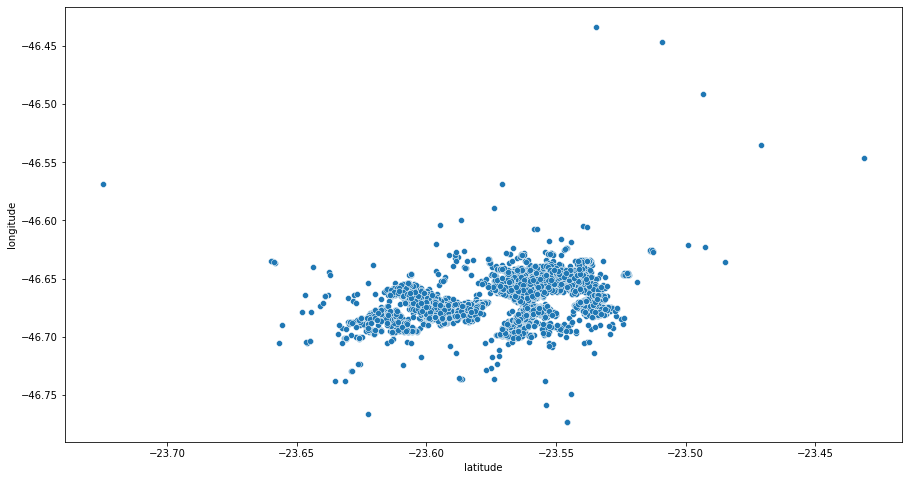

In [115]:
#Distribuição das regiões
plt.figure(figsize = (15,8))
sns.scatterplot(df_full["latitude"], df_full["longitude"])

In [118]:
#Criação dos clusters
agc = AgglomerativeClustering(n_clusters =7, affinity='euclidean', linkage='ward')
df_full['region_cluster'] = agc.fit_predict(df_full[['latitude','longitude']])

kmeans = KMeans(7)
clusters = kmeans.fit_predict(df_full[['latitude','longitude']])
df_full['region_cluster'] = kmeans.predict(df_full[['latitude','longitude']])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [120]:
df_full.head()

id  location_id  rent_type  ...  latitude  longitude  region_cluster
0  47921         6023  long stay  ... -23.57186  -46.65985               4
1  47947         6034  long stay  ... -23.57141  -46.65992               4
2  47922        17486  long stay  ... -23.57084  -46.65769               4
3  47923        17551  long stay  ... -23.57018  -46.66330               4
4  47925        17843  long stay  ... -23.57263  -46.65829               4

[5 rows x 9 columns]

In [119]:
df_full["region_cluster"].value_counts()

4    1443
1    1018
0     917
3     738
6     732
5     674
2     494
Name: region_cluster, dtype: int64

In [125]:
agc = AgglomerativeClustering(n_clusters =7, affinity='euclidean', linkage='ward')
df_full['region_cluster'] = agc.fit_predict(df_full[['latitude','longitude']])

kmeans = KMeans(7)
clusters = kmeans.fit_predict(df_full[['latitude','longitude']])
df_full['region_cluster'] = kmeans.predict(df_full[['latitude','longitude']])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


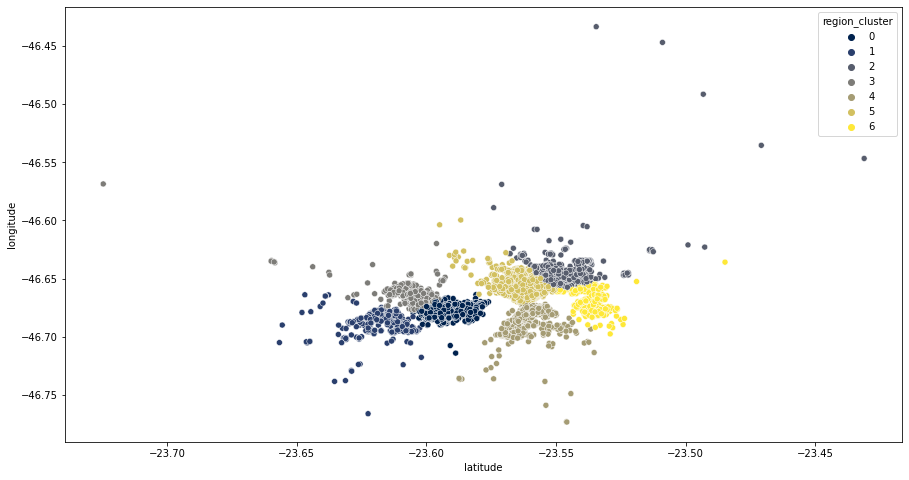

In [129]:
plt.figure(figsize = (15,8))
sns.scatterplot(data=df_full, x="latitude", y="longitude", hue="region_cluster", palette='cividis')

In [127]:
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(df_full[['latitude','longitude']])
    Sum_of_squared_distances.append(km.inertia_)

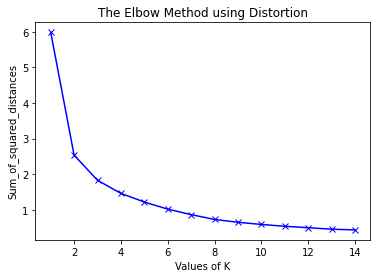

In [128]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Sum_of_squared_distances')
plt.title('The Elbow Method using Distortion')
plt.show()

In [97]:
display(df_full['region_cluster'])

0       6
1       6
2       6
3       6
4       6
       ..
6016    1
6017    4
6018    5
6019    1
6020    1
Name: region_cluster, Length: 6016, dtype: int32

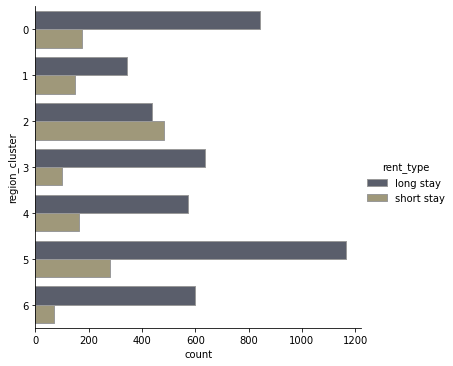

In [130]:
sns.catplot(y="region_cluster", hue="rent_type", kind="count",
            palette="cividis", edgecolor=".6",
            data=df_full)

- Comparação da longa e curta estadia por região

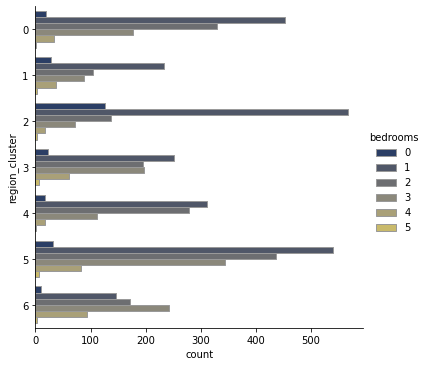

In [131]:
sns.catplot(y="region_cluster", hue="bedrooms", kind="count",
            palette="cividis", edgecolor=".6",
            data=df_full)

- Distribuição de quantidade de quartos por região

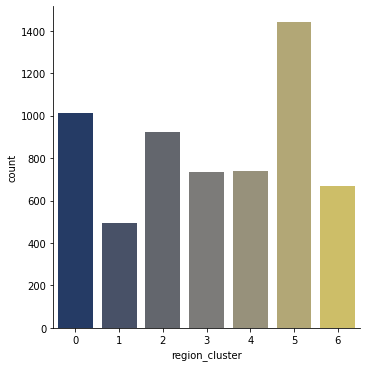

In [132]:
sns.catplot(x="region_cluster", kind="count", palette='cividis', data=df_full)

- Contagem de apartamentos por região

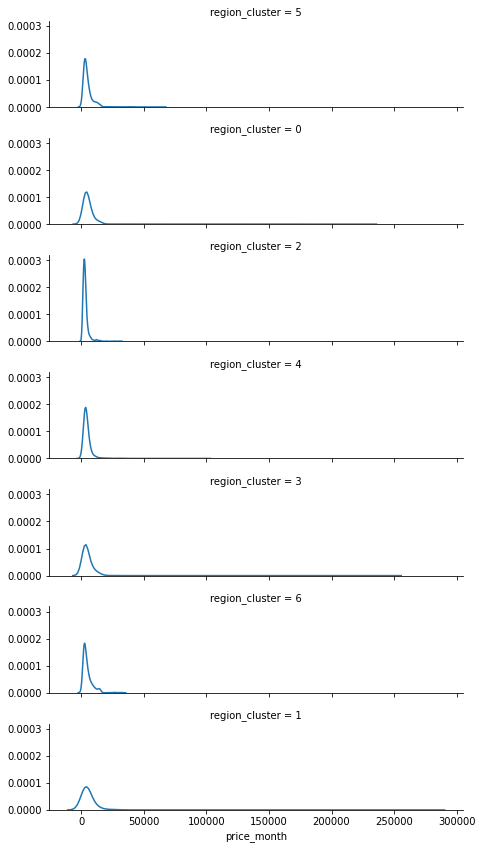

In [133]:
ordered_days = df_full.region_cluster.value_counts().index
g = sns.FacetGrid(df_full, row="region_cluster", row_order=ordered_days,
                  height=1.7, aspect=4,)
g.map(sns.kdeplot, "price_month")

- Distribuição dos valores mensais por região 



---



---



# Modelo de Regressão


In [134]:
rent_type = pd.get_dummies(df_full.rent_type)
region_cluster = pd.get_dummies(df_full.region_cluster)
df_model = pd.concat([df_full, rent_type, region_cluster], axis=1)

In [135]:
df_model.head()

id  location_id  rent_type  price_month  sqm  bedrooms  ...  1  2  3  4  5  6
0  47921         6023  long stay         5700   65         2  ...  0  0  0  0  1  0
1  47947         6034  long stay         3000   30         1  ...  0  0  0  0  1  0
2  47922        17486  long stay         2300   29         1  ...  0  0  0  0  1  0
3  47923        17551  long stay         3880  130         2  ...  0  0  0  0  1  0
4  47925        17843  long stay        12000  280         3  ...  0  0  0  0  1  0

[5 rows x 18 columns]

In [137]:
df_model.drop(columns=['id', 'location_id', "rent_type"], inplace=True )

In [139]:
df_short_stay = df_model[df_model["short stay"]==1]
df_short_stay.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1419 entries, 43 to 6020
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   price_month     1419 non-null   int64  
 1   sqm             1419 non-null   int64  
 2   bedrooms        1419 non-null   int64  
 3   latitude        1419 non-null   float64
 4   longitude       1419 non-null   float64
 5   region_cluster  1419 non-null   int32  
 6   long stay       1419 non-null   uint8  
 7   short stay      1419 non-null   uint8  
 8   0               1419 non-null   uint8  
 9   1               1419 non-null   uint8  
 10  2               1419 non-null   uint8  
 11  3               1419 non-null   uint8  
 12  4               1419 non-null   uint8  
 13  5               1419 non-null   uint8  
 14  6               1419 non-null   uint8  
dtypes: float64(2), int32(1), int64(3), uint8(9)
memory usage: 84.5 KB


In [140]:
df_long_stay = df_model[df_model["long stay"]==1]
df_long_stay.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4597 entries, 0 to 5604
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   price_month     4597 non-null   int64  
 1   sqm             4597 non-null   int64  
 2   bedrooms        4597 non-null   int64  
 3   latitude        4597 non-null   float64
 4   longitude       4597 non-null   float64
 5   region_cluster  4597 non-null   int32  
 6   long stay       4597 non-null   uint8  
 7   short stay      4597 non-null   uint8  
 8   0               4597 non-null   uint8  
 9   1               4597 non-null   uint8  
 10  2               4597 non-null   uint8  
 11  3               4597 non-null   uint8  
 12  4               4597 non-null   uint8  
 13  5               4597 non-null   uint8  
 14  6               4597 non-null   uint8  
dtypes: float64(2), int32(1), int64(3), uint8(9)
memory usage: 273.8 KB


In [55]:
df_full.head()

id  location_id  rent_type  ...  latitude  longitude  region_cluster
0  47921         6023  long stay  ... -23.57186  -46.65985               4
1  47947         6034  long stay  ... -23.57141  -46.65992               4
2  47922        17486  long stay  ... -23.57084  -46.65769               4
3  47923        17551  long stay  ... -23.57018  -46.66330               4
4  47925        17843  long stay  ... -23.57263  -46.65829               4

[5 rows x 9 columns]



---



---



# Long Stay

In [141]:
x = df_long_stay.drop(columns=["price_month", "long stay", "short stay", "region_cluster", 0, 1, 2, 3, 4, 5, 6, "bedrooms", "latitude", "longitude"])
x

sqm
0      65
1      30
2      29
3     130
4     280
...   ...
5600  189
5601  116
5602   45
5603   60
5604  139

[4597 rows x 1 columns]

In [142]:
y = df_long_stay.drop(columns=["sqm", "bedrooms", "region_cluster","long stay", "short stay", 0, 1, 2, 3, 4, 5, 6, "latitude", "longitude"])
y

price_month
0            5700
1            3000
2            2300
3            3880
4           12000
...           ...
5600         5800
5601         3219
5602         2110
5603         2600
5604         6900

[4597 rows x 1 columns]

In [143]:
#create model and fit
model = LinearRegression()
model.fit(x, y)
teste = model.fit(x, y)

In [147]:
#Get results
r_sq = model.score(x, y)
intercept, coefficients = model.intercept_, model.coef_

In [148]:
est = sm.OLS(y, x)
est2 = est.fit()
print(est2.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


                                 OLS Regression Results                                
Dep. Variable:            price_month   R-squared (uncentered):                   0.811
Model:                            OLS   Adj. R-squared (uncentered):              0.811
Method:                 Least Squares   F-statistic:                          1.968e+04
Date:                Fri, 20 Aug 2021   Prob (F-statistic):                        0.00
Time:                        02:36:30   Log-Likelihood:                         -42280.
No. Observations:                4597   AIC:                                  8.456e+04
Df Residuals:                    4596   BIC:                                  8.457e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

- O modelo para Long Stay tem o R-squared com valor 0.811 e o Coeficiente 39.133

In [150]:
#predict
y_pred = model.predict(x)

In [152]:
#show results
print('coefficient of determination:', r_sq) #coefficient of determination
print('intercept:', intercept)
print('coefficients:', coefficients, sep='\n')
print('predicted response:', y_pred, sep='\n')

# Help para interpretação das métricas
# https://corporatefinanceinstitute.com/resources/knowledge/other/coefficient-of-determination/ 

coefficient of determination: 0.49293016549945745
intercept: [1807.7480988]
coefficients:
[[27.68271208]]
predicted response:
[[3607.12438412]
 [2638.22946126]
 [2610.54674918]
 ...
 [3053.47014249]
 [3468.71082372]
 [5655.64507819]]




---




# Short Stay

In [153]:
x = df_short_stay.drop(columns=["price_month", "long stay", "short stay", "region_cluster", 0, 1, 2, 3, 4, 5, 6, "bedrooms", "latitude", "longitude"])
x

sqm
43     50
45     50
72     25
86     50
90     25
...   ...
6016   50
6017   25
6018   50
6019   97
6020   50

[1419 rows x 1 columns]

In [154]:
y = df_short_stay.drop(columns=["sqm", "bedrooms", "region_cluster","long stay", "short stay", 0, 1, 2, 3, 4, 5, 6, "latitude", "longitude"])
y

price_month
43           1980
45           6944
72           4340
86           4191
90           1442
...           ...
6016         3549
6017         5245
6018         5022
6019         6404
6020         5375

[1419 rows x 1 columns]

In [155]:
#create model and fit
model = LinearRegression()
model.fit(x, y)
teste = model.fit(x, y)

In [156]:
#Get results
r_sq = model.score(x, y)
intercept, coefficients = model.intercept_, model.coef_

In [157]:
est = sm.OLS(y, x)
est2 = est.fit()
print(est2.summary())

                                 OLS Regression Results                                
Dep. Variable:            price_month   R-squared (uncentered):                   0.220
Model:                            OLS   Adj. R-squared (uncentered):              0.220
Method:                 Least Squares   F-statistic:                              400.7
Date:                Fri, 20 Aug 2021   Prob (F-statistic):                    1.05e-78
Time:                        02:40:51   Log-Likelihood:                         -15498.
No. Observations:                1419   AIC:                                  3.100e+04
Df Residuals:                    1418   BIC:                                  3.100e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

- O modelo para Short Stay tem o R-squared com valor 0.220 e o Coeficiente 93.485

In [158]:
#predict
y_pred = model.predict(x)

In [159]:
#show results
print('coefficient of determination:', r_sq) #coefficient of determination
print('intercept:', intercept)
print('coefficients:', coefficients, sep='\n')
print('predicted response:', y_pred, sep='\n')


coefficient of determination: 0.05197851001302367
intercept: [2391.7803487]
coefficients:
[[68.34152686]]
predicted response:
[[5808.85669164]
 [5808.85669164]
 [4100.31852017]
 ...
 [5808.85669164]
 [9020.908454  ]
 [5808.85669164]]


In [161]:
df_price.head()

id  sqm  bedrooms   latitude  longitude
0   1   90         2 -23.562626 -46.661460
1   2   55         1 -23.564739 -46.664567
2   3  120         3 -23.557638 -46.665484
3   4   75         2 -23.587535 -46.677992
4   5  140         3 -23.584378 -46.678645

In [169]:
df_price['short_stay'] = df_price['bedrooms'] * 93.48     #valor do coeficiente para o short_stay

df_price['long_stay'] = df_price['bedrooms'] * 39.13      #valor do coeficiente para o long_stay


In [171]:
df_price.head(6)

id  sqm  bedrooms   latitude  longitude  short_stay  long_stay
0   1   90         2 -23.562626 -46.661460      186.96      78.26
1   2   55         1 -23.564739 -46.664567       93.48      39.13
2   3  120         3 -23.557638 -46.665484      280.44     117.39
3   4   75         2 -23.587535 -46.677992      186.96      78.26
4   5  140         3 -23.584378 -46.678645      280.44     117.39
5   6   40         1 -23.583394 -46.681149       93.48      39.13



---



# Conclusão

Foi realizada uma Regressão Linear simples, contudo, o P>t mostra que a variável utilizada não foi eficiente para a previsão. Para um modelo mais assertivo será preciso uma investigação mais profunda e re-treino do modelo com outras variáveis para que se chegue num resultado confiável para o negócio 